# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

Признак N_Days исключён, поскольку он приводит к ликам. Это значение всегда указывается постфактум вместе с таргетом. Если наша цель — создание "честной" медицинской ML-модели, то на момент прогнозирования вероятности исхода заболевания мы ничего не знаем о том, сколько дней проживёт пациент.

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [4]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [5]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL означает, что пациент выжил благодаря трансплантации печени. А информации о том, кому была сделана или назначена трансплантация, в данных нет. Поэтому мы не можем корректно предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних факторов (решение врача, наличие органа, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того, CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [6]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

Наблюдаем выраженный дисбаланс классов: только более трети пациентов страдают тяжёлой формой заболевания. Это будет учтено при обучении ML-модели и оценке качества.  

In [7]:
df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [8]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [9]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Напишем классы-преобразователи для переменных разных типов.

In [10]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_


class PercentileClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в указанных колонках по перцентилям."""
    def __init__(self, columns, lower=0.0, upper=99.5):
        self.columns = columns
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            low = np.percentile(X[col], self.lower)
            up = np.percentile(X[col], self.upper)
            self.bounds_[col] = (low, up)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns)
        for col, (low, up) in self.bounds_.items():
            X_df[col] = X_df[col].clip(low, up)
        return X_df.values
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns, dtype=object)
        return np.asarray(input_features, dtype=object)

Создадим несколько пайплайнов с разными видами преобразований, из которых затем выберем лучший.

Ниже указаны четыре стратегии предобработки числовых признаков, которые имеют скошенное распределение с выбросами:

- Вариант 1: log + standard scaler
- Вариант 2: log + percentile clip + standard scaler
- Вариант 3: log + robust scaler
- Вариант 4: log + percentile clip + robust scaler

**Log-преобразование** стабилизирует дисперсию и уменьшает асимметрию, делает данные более нормальными.

**Percentile Clipper** обрезает экстремальные выбросы по перцентилям (в нашем случае — длинные правые хвосты), защищает от сильного влияния аномалий.

**Standard Scaler** стандартизует данные (среднее=0, дисперсия=1), хорошо подходит для нормально распределённых данных.

**Robust Scaler** масштабирует на основе медианы и межквартильного расстояния, более устойчив к выбросам.

In [11]:
def make_preprocessor(strategy="log_standard"):

    log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

    # Вариант 1: log + standard
    if strategy == "log_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", StandardScaler())
        ])

    # Вариант 2: log + percentile clip + standard
    elif strategy == "log_clip_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=99)),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", StandardScaler())
        ])

    # Вариант 3: log + robust
    elif strategy == "log_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", RobustScaler())
        ])
    
    # Вариант 4: log + percentile clip + robust scaler 
    elif strategy == "log_clip_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=99)),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", RobustScaler())
        ])        
          
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num_skewed", skewed_pipe, skewed_numeric),
            ("num_symmetric", symmetric_pipe, symmetric_numeric),
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OneHotEncoder(drop="first", sparse_output=False), multi_category_features)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    return preprocessor

Применим разные стратегии преобразования к X_train, чтобы затем сравнить их между собой.

In [12]:
STRATEGIES = ["log_standard", "log_clip_standard", "log_robust", "log_clip_robust"]

def apply_strategies(X_train, strategies=STRATEGIES):
    outputs = {}
    for s in strategies:
        processor = make_preprocessor(s)
        X_proc = processor.fit_transform(X_train)
        cols = processor.get_feature_names_out()
        outputs[s] = pd.DataFrame(X_proc, columns=cols, index=X_train.index)
    return outputs

In [13]:
processed = apply_strategies(X_train)

Теперь выберем наиболее подходящий метод с помощью визуализаций.

In [14]:
def plot_skewed_changes(X_train, processed, features=skewed_numeric, bins=30):
    """
    Для каждого skewed признака:
    - слева оригинал
    - справа - версии после разных стратегий
    """
    n = len(features)
    fig, axes = plt.subplots(n, 1 + len(processed), figsize=(5*(1+len(processed)), 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax)
        ax.set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            ax = axes[i, j]
            sns.histplot(processed[s][col], bins=bins, ax=ax)
            ax.set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
    

def plot_symmetric_changes(X_train, X_processed, features=symmetric_numeric, bins=30):
    """
    Для каждого symmetric признака:
    - слева оригинал
    - справа - распределение после выбранной стратегии (standard или robust)
    """
    n = len(features)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax, color='steelblue', alpha=0.7)
        ax.set_title(f"{col} (до)")
        
    for i, col in enumerate(features):
        ax = axes[i, 1]
        sns.histplot(X_processed[col], bins=bins, ax=ax, color='steelblue', alpha=0.7)
        ax.set_title(f"{col} (после)")    

    plt.tight_layout()
    plt.show()    
    
    
def plot_boxplots(X_train, processed, features=skewed_numeric):
    n = len(features)
    fig, axes = plt.subplots(n, 1+len(processed), figsize=(5*(1+len(processed)), 2.5*n), squeeze=False)

    for i, col in enumerate(features):
        axes[i, 0].boxplot(X_train[col], vert=True)
        axes[i, 0].set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            axes[i, j].boxplot(processed[s][col].dropna(), vert=True)
            axes[i, j].set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
    
    
def summarize_changes(X_train, processed, numeric_features=numeric_features):
    print("\n=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===\n")

    for col in numeric_features:
        print(f"\nПРИЗНАК: {col}")
        print(f"  • исходный skew: {X_train[col].skew():.2f}")

        for strat, df_proc in processed.items():
            s = df_proc[col]
            skew = s.skew()
            z = (s - s.mean()) / (s.std() + 1e-9)
            out = (np.abs(z) > 3).mean()

            print(f"    - {strat}: skew={skew:.2f}, доля выбросов(|z|>3)={out:.3f}")

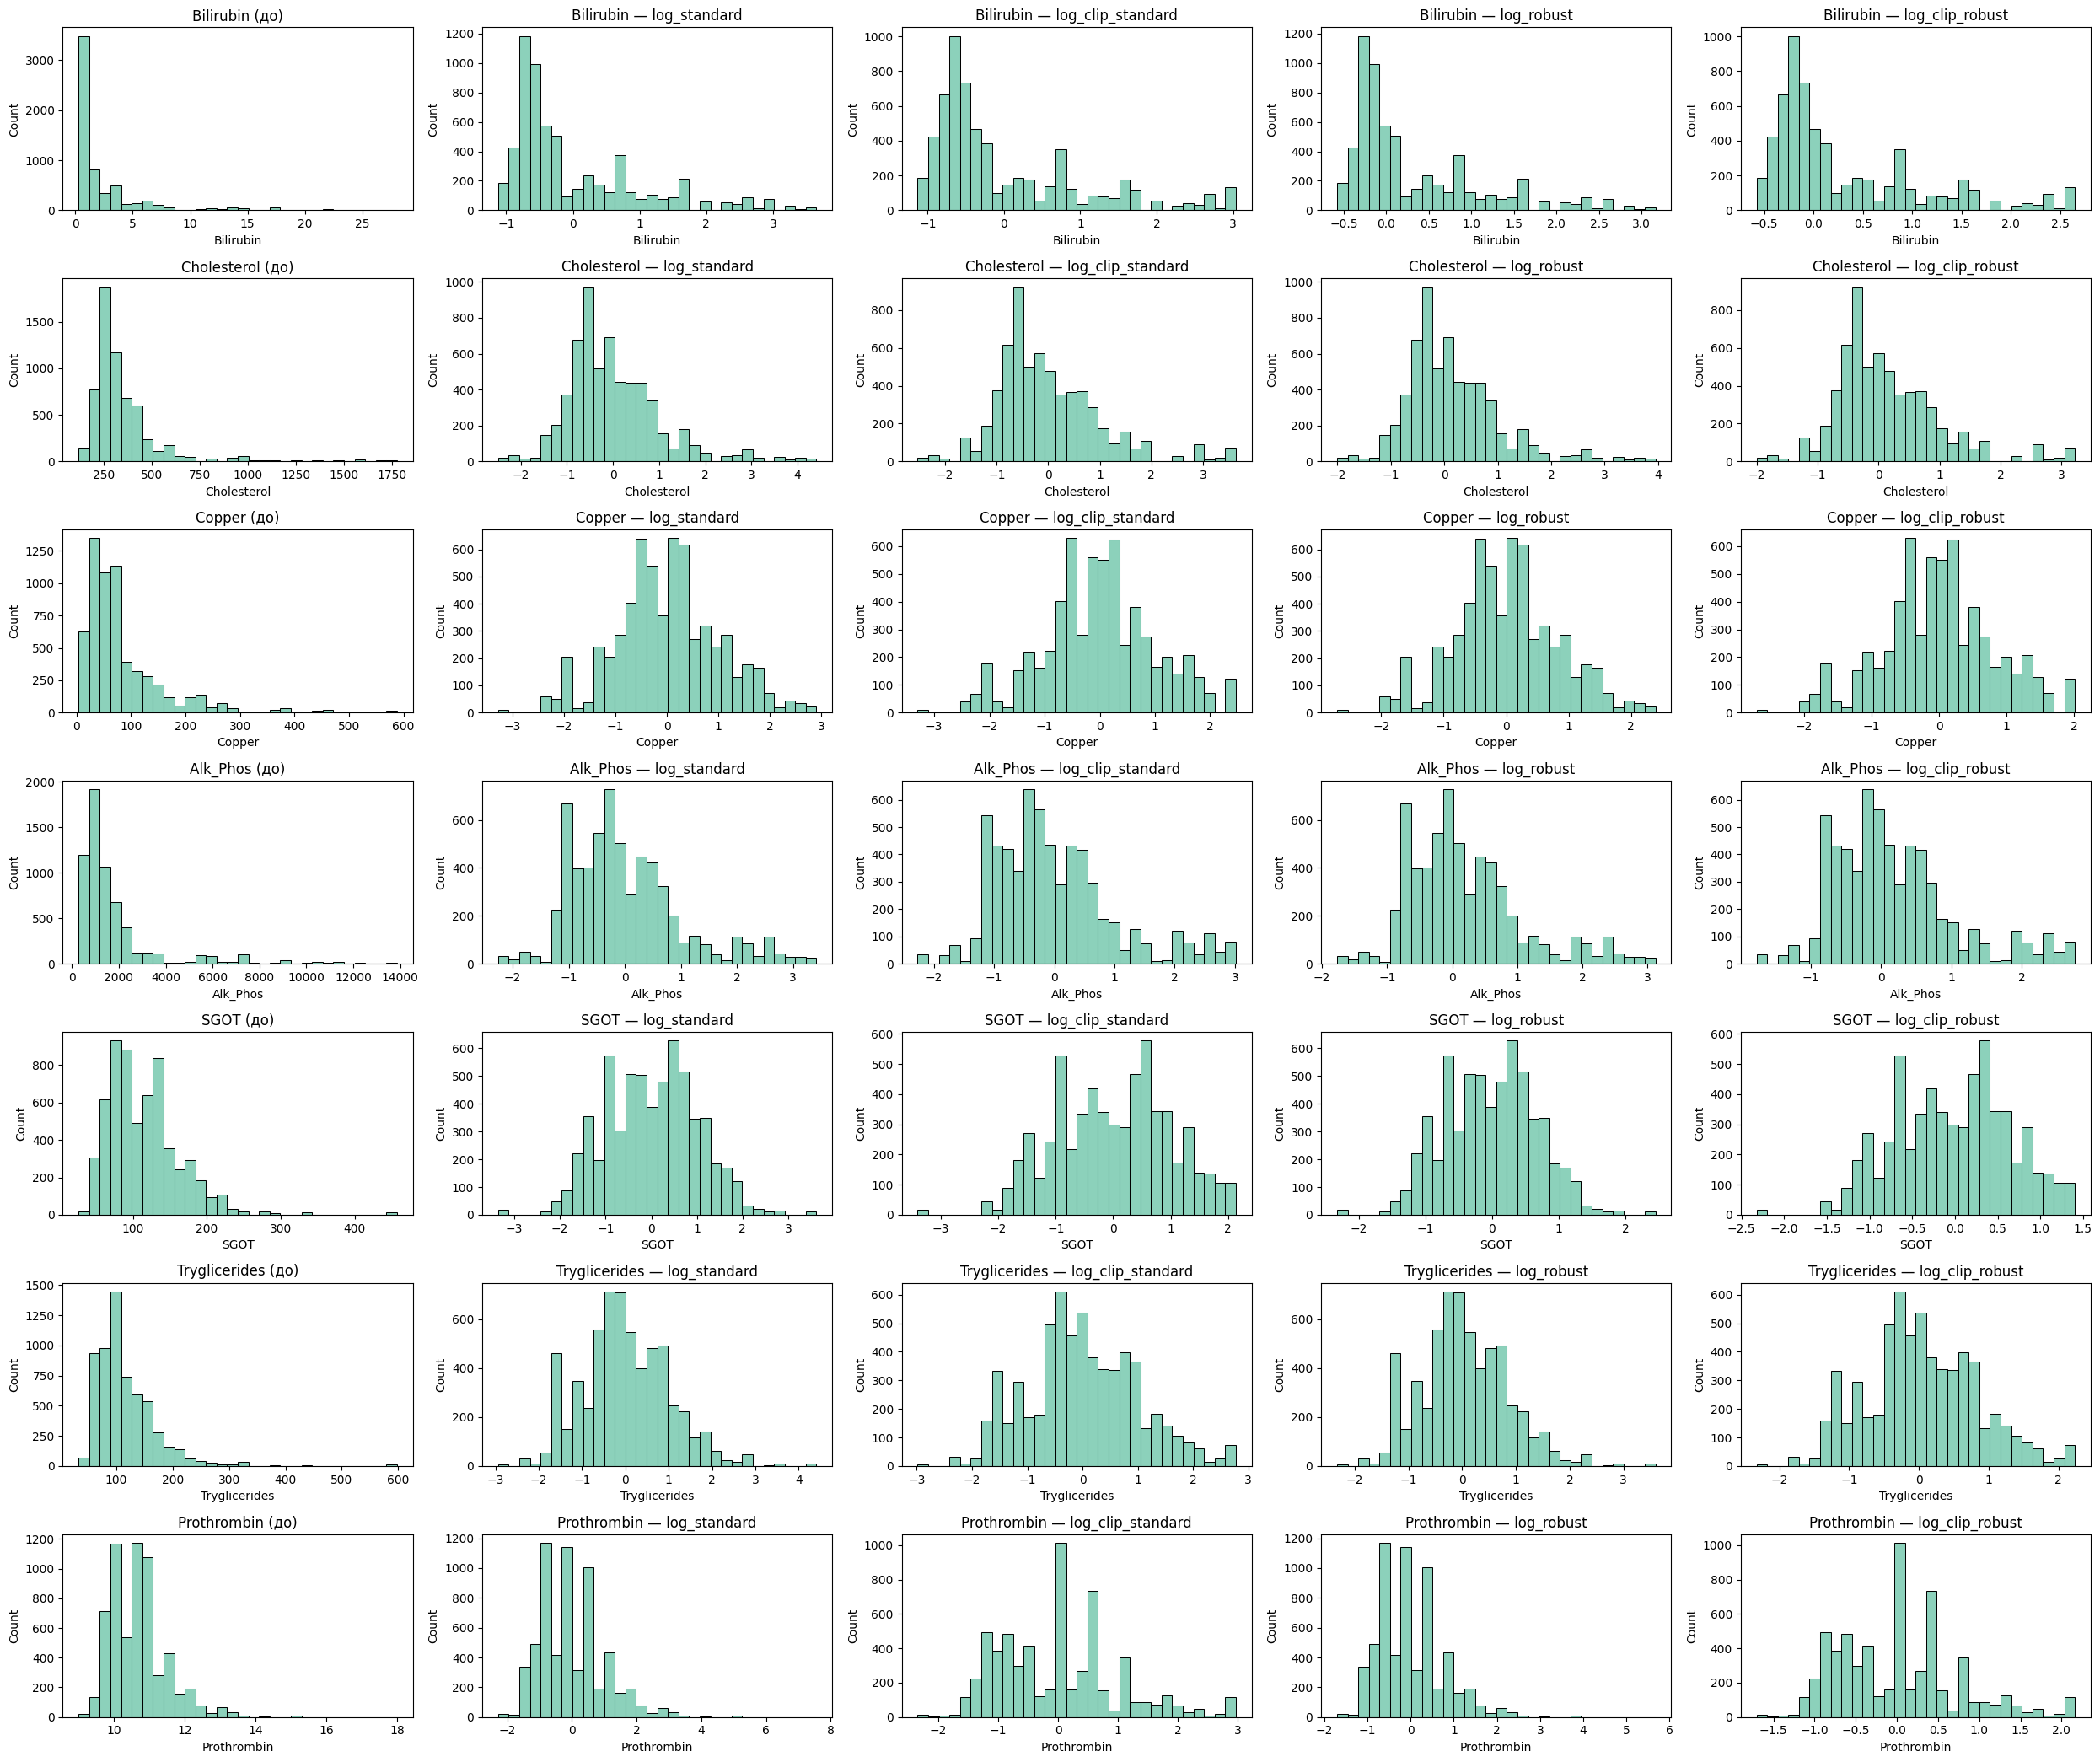

In [15]:
plot_skewed_changes(X_train, processed)

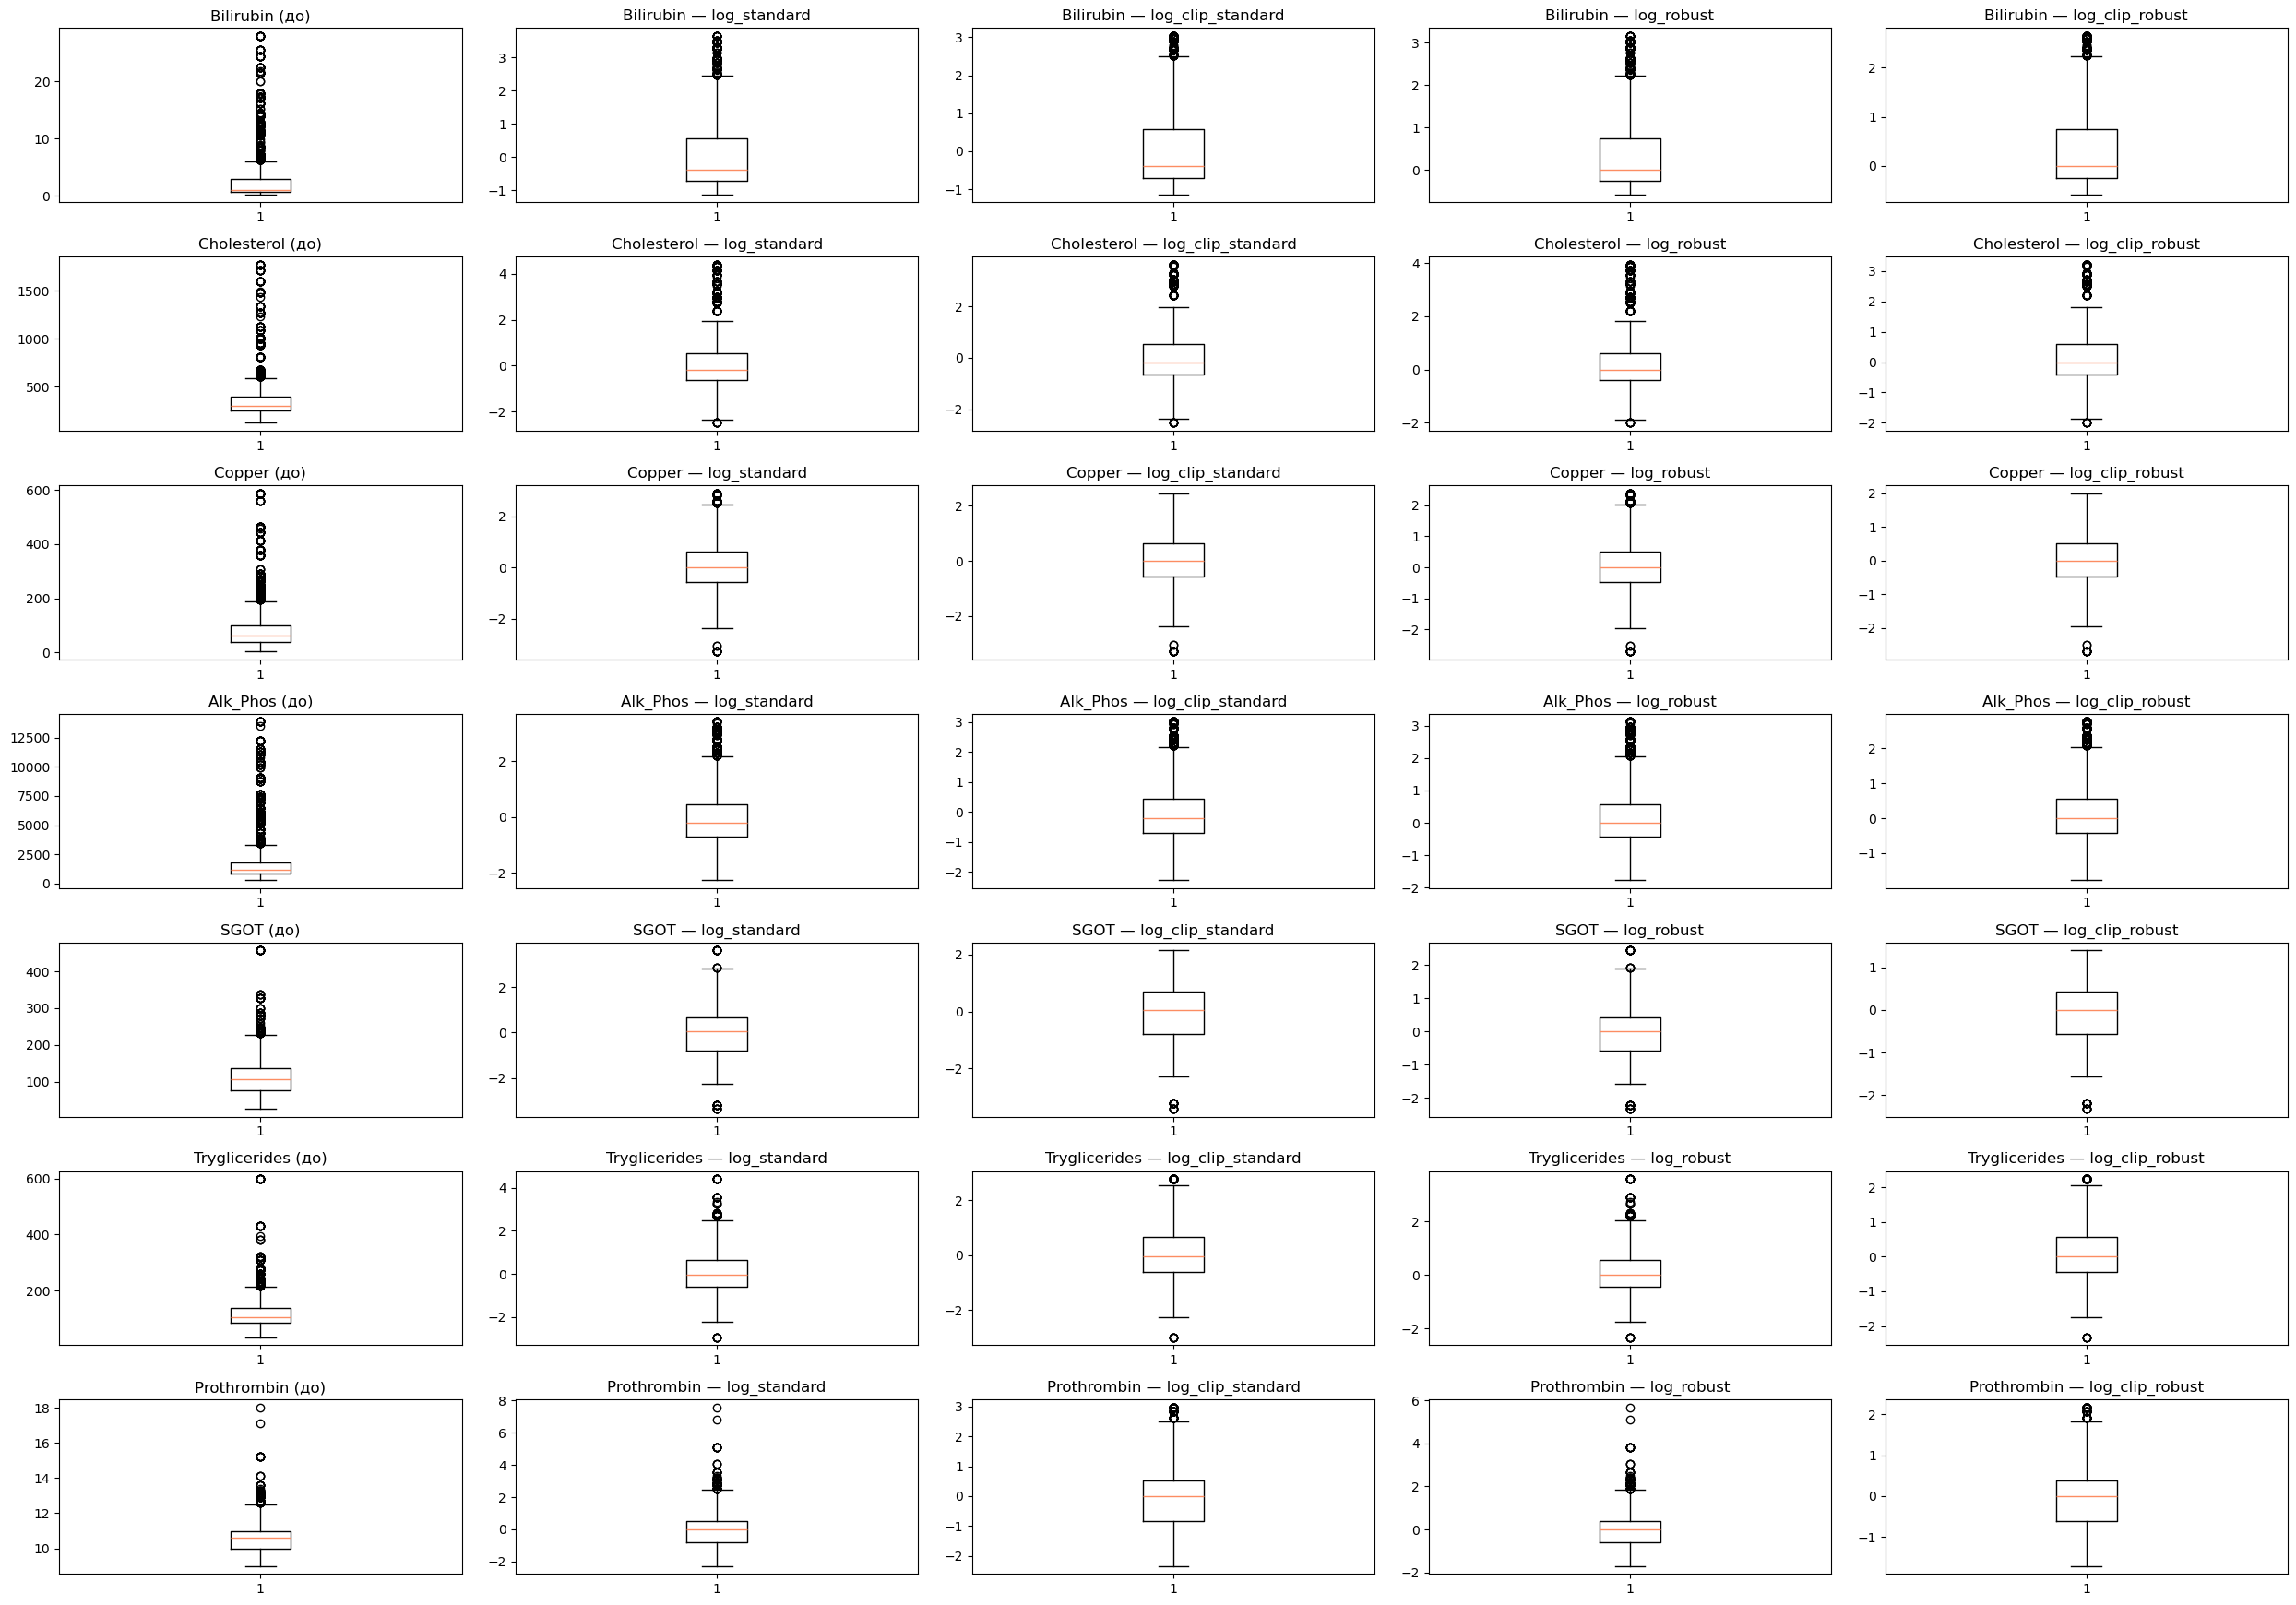

In [ ]:
plot_boxplots(X_train, processed)

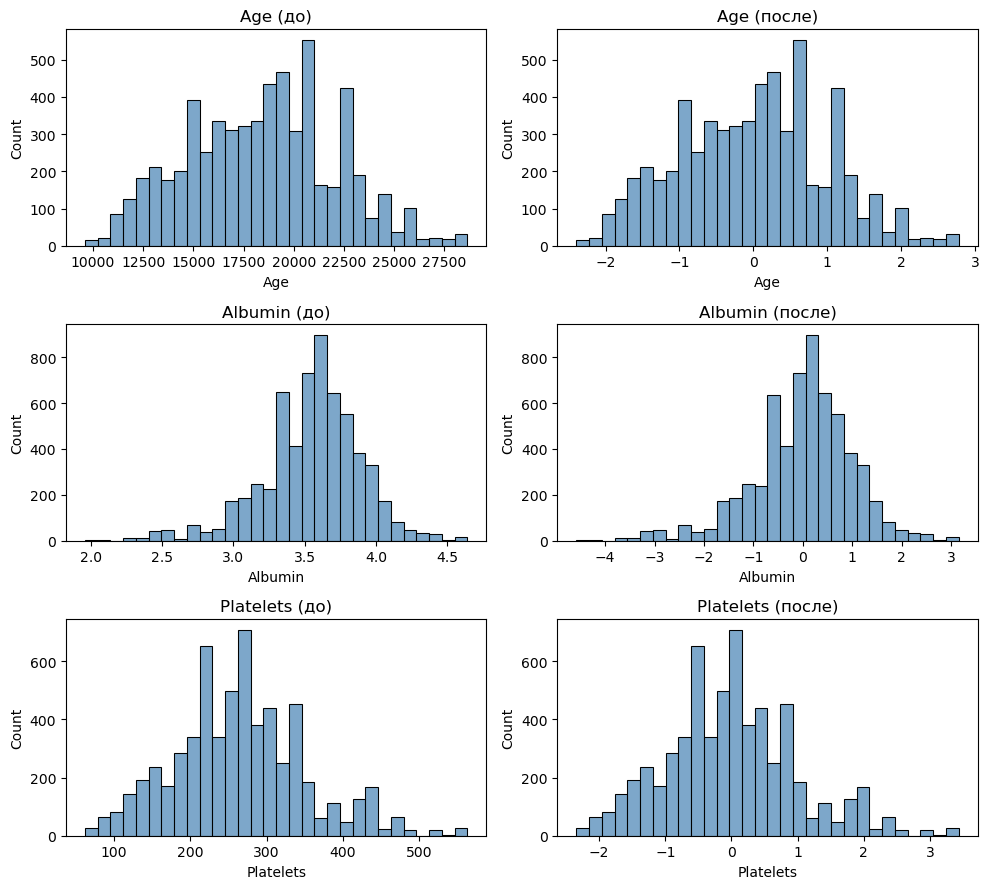

In [ ]:
plot_symmetric_changes(X_train, processed["log_clip_standard"])

In [ ]:
summarize_changes(X_train, processed)


=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===


ПРИЗНАК: Age
  • исходный skew: 0.07
    - log_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_robust: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_robust: skew=0.07, доля выбросов(|z|>3)=0.000

ПРИЗНАК: Bilirubin
  • исходный skew: 3.30
    - log_standard: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_standard: skew=1.38, доля выбросов(|z|>3)=0.012
    - log_robust: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_robust: skew=1.38, доля выбросов(|z|>3)=0.012

ПРИЗНАК: Cholesterol
  • исходный skew: 3.63
    - log_standard: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_standard: skew=1.12, доля выбросов(|z|>3)=0.017
    - log_robust: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_robust: skew=1.12, доля выбросов(|z|>3)=0.017

ПРИЗНАК: Albumin
  • исходный skew: -0.58
    - log_standard: skew=-0.58, доля выбросов(|z|>3)=0.015
    - 

Для числовых признаков выберем стратегию log_clip_standard: логарифмирование, мягкий клиппинг правого хвоста по 99-му перцентилю и последующая стандартизация. Логарифмирование снижает правую асимметрию признаков и "сжимает" длинные хвосты, клиппинг убирает единичные экстремальные значения, которые непропорционально влияют на оценку коэффициентов, а StandardScaler приводит все признаки к сопоставимому масштабу. В результате распределения становятся ближе к симметричным, доля выбросов снижается до долей процентов, что делает наши данные более подходящими для обучения и интерпретации логистической регрессии.

# Этап II. Применение логистической регрессии

Инициализируем выбранный метод предобработки.

In [16]:
preprocessor = make_preprocessor("log_clip_standard")

Посмотрим, как будет выглядеть предобработанный датасет после указанных выше преобразований.

In [17]:
df_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

In [18]:
df_proc.head()

,Bilirubin,Cholesterol,Copper,Alk_Phos,SGOT,Tryglicerides,Prothrombin,Age,Albumin,Platelets,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema_S,Edema_Y,Stage_2.0,Stage_3.0,Stage_4.0
0,0.365671,1.416713,0.817915,-0.049729,0.847200,0.831303,0.134652,-1.680801,0.151520,0.296398,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.808440,0.328017,-0.216828,-0.102753,0.899275,1.486451,-0.982436,0.021346,1.017782,-1.006539,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.995877,-1.554002,2.466007,-0.787794,1.389449,1.527506,2.965277,-0.377052,-2.302889,-0.868174,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2.525029,0.116510,0.430788,0.150109,0.627402,-0.070790,0.533971,-0.429158,0.151520,0.134972,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.638962,0.427694,0.664009,-0.471459,0.509857,-0.147094,0.664862,0.079423,0.555776,0.008138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
df_proc.describe().T

,count,mean,std,min,25%,50%,75%,max
Bilirubin,6104.0,-1.292108e-16,1.000082,-1.131869,-0.714008,-0.384863,0.579382,3.037639
Cholesterol,6104.0,-8.916706e-16,1.000082,-2.535609,-0.645027,-0.165635,0.537152,3.637798
Copper,6104.0,3.026558e-16,1.000082,-3.301729,-0.584547,0.009024,0.638636,2.466007
Alk_Phos,6104.0,-5.948351e-16,1.000082,-2.269281,-0.707868,-0.203528,0.459455,3.015599
SGOT,6104.0,1.070936e-16,1.000082,-3.405858,-0.802868,0.048940,0.684177,2.136337
Tryglicerides,6104.0,4.714446e-16,1.000082,-2.985370,-0.596702,-0.045843,0.666602,2.776406
Prothrombin,6104.0,-1.456240e-15,1.000082,-2.341653,-0.838396,-0.000733,0.533971,2.965277
Age,6104.0,-1.277557e-16,1.000082,-2.394281,-0.765137,0.081052,0.614330,2.776208
Albumin,6104.0,-8.291023e-16,1.000082,-4.584045,-0.570365,0.093769,0.642402,3.154562
Platelets,6104.0,2.165153e-16,1.000082,-2.344068,-0.614505,-0.003393,0.596189,3.432672


Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 1. Baseline

Логистическая регрессия с регуляризацией l2, с подобранными C и solver на кросс-валидации по recall.

In [ ]:
base_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_base = GridSearchCV(
    base_pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_base.fit(X_train, y_train)
print("Базовая логрегрессия (без учёта дисбаланса)")
print("Лучшие параметры:", gs_base.best_params_)
print("Лучший recall на кросс-валидации:", gs_base.best_score_)

Базовая логрегрессия (без учёта дисбаланса)
Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.6871513232399863


In [ ]:
y_pred_base = cross_val_predict(
    gs_base.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (базовая модель без учёта дисбаланса):")
print(classification_report(y_train, y_pred_base))

Отчёт по классам (базовая модель без учёта дисбаланса):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3972
           1       0.80      0.69      0.74      2132

    accuracy                           0.83      6104
   macro avg       0.82      0.80      0.81      6104
weighted avg       0.83      0.83      0.83      6104



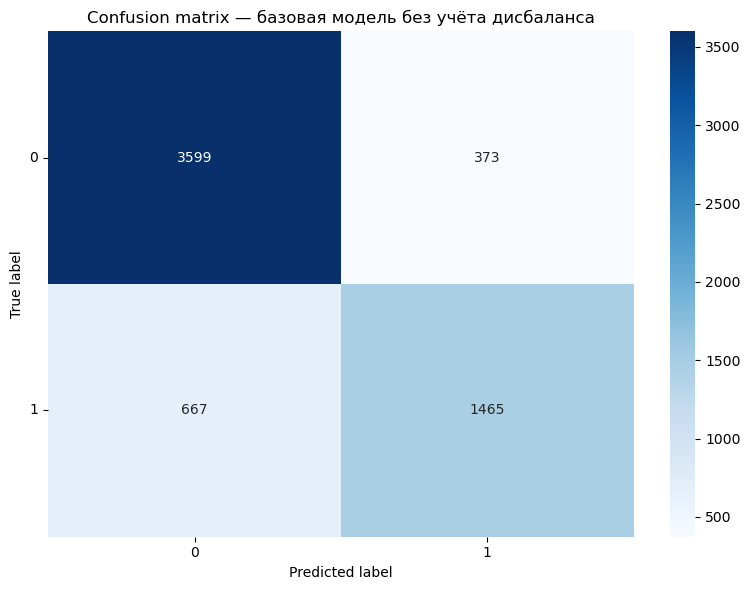

In [ ]:
cm = confusion_matrix(y_train, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — базовая модель без учёта дисбаланса")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Видим, что:

Recall класса 1 = 0.69 => модель пропускает ~31% тяжёлых пациентов.

Precision класса 1 = 0.80 => ложноположительных относительно немного.

В целом модель "бережёт" класс 0, но недооценивает класс 1.

Вывод: хороший результат по precision, но слишком низкий recall для тяжёлых пациентов.

## 2. Взвешивание классов

Чтобы сбалансировать важность классов, присвоим объектам миноритарного класса больший вес. class_weight="balanced" автоматически подберёт необходимое значение.

In [ ]:
cw_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_cw = GridSearchCV(
    cw_pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_cw.fit(X_train, y_train)
print("Логрегрессия с class_weight='balanced'")
print("Лучшие параметры:", gs_cw.best_params_)
print("Лучший recall на кросс-валидации:", gs_cw.best_score_)

Логрегрессия с class_weight='balanced'
Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.7912777209706325


In [ ]:
y_pred_cw = cross_val_predict(
    gs_cw.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с весами классов):")
print(classification_report(y_train, y_pred_cw))

Отчёт по классам (модель с весами классов):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.72      0.79      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.82      0.81      6104
weighted avg       0.83      0.82      0.82      6104



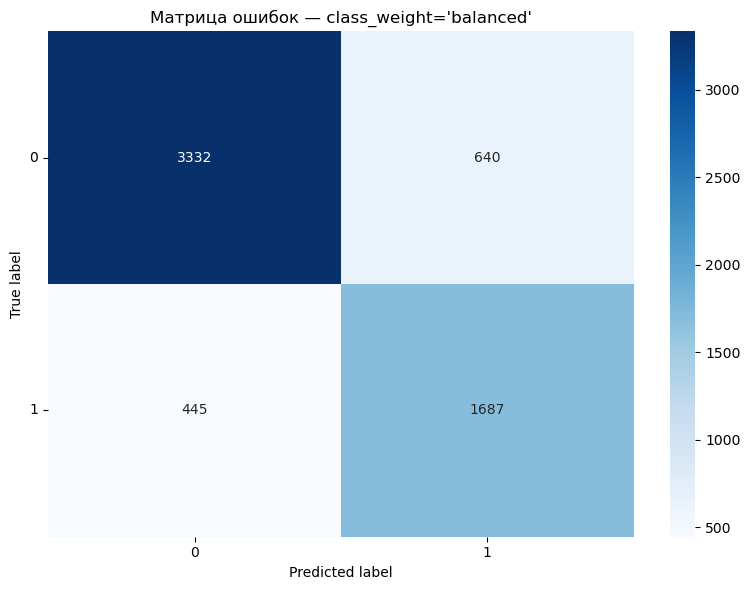

In [ ]:
cm = confusion_matrix(y_train, y_pred_cw)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — class_weight='balanced'")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Видим, что:

Recall класса 1 ~0.8 => модель пропускает меньше тяжёлых пациентов.

Precision класса 1 = 0.72 => больше ложноположительных, но метрика всё ещё приемлемая.

Вывод: более стабильный вариант, чем бейслайн.

## 3. Downsampling класса большинства

Используем простой способ, чтобы выровнять пропорцию классов: просто удалим некоторые объекты класса большинства.

In [ ]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_us = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us.fit(X_train, y_train)
print("RandomDownSampler + логрегрессия")
print("Лучшие параметры:", gs_us.best_params_)
print("Лучший recall на кросс-валидации:", gs_us.best_score_)

RandomDownSampler + логрегрессия
Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.7936163428659387


In [ ]:
y_pred_us = cross_val_predict(
    gs_us.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.79      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



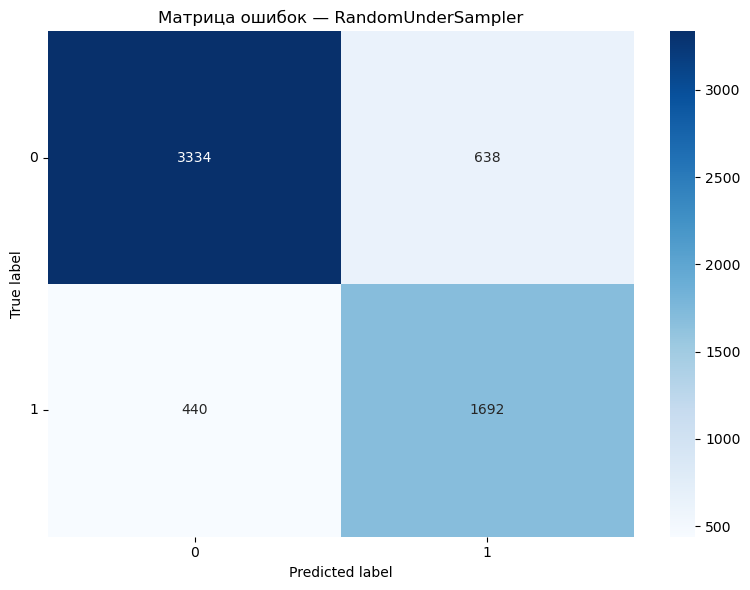

In [ ]:
cm = confusion_matrix(y_train, y_pred_us)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: почти то же самое, что class_weight, но потеря данных бессмысленна.

## 4. Upsampling класса меньшинства

Теперь поступим наоборот: случайным образом скопируем объекты из класса меньшинства так, чтобы их кол-во приравнять к мажоритарному классу.

In [ ]:
pipeline_os = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_os = GridSearchCV(
    pipeline_os,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os.fit(X_train, y_train)
print("RandomOverSampler + логрегрессия")
print("Лучшие параметры:", gs_os.best_params_)
print("Лучший recall на кросс-валидации:", gs_os.best_score_)

RandomOverSampler + логрегрессия
Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.788936900089059


In [ ]:
y_pred_os = cross_val_predict(
    gs_os.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.72      0.79      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.81      0.81      6104
weighted avg       0.83      0.82      0.82      6104



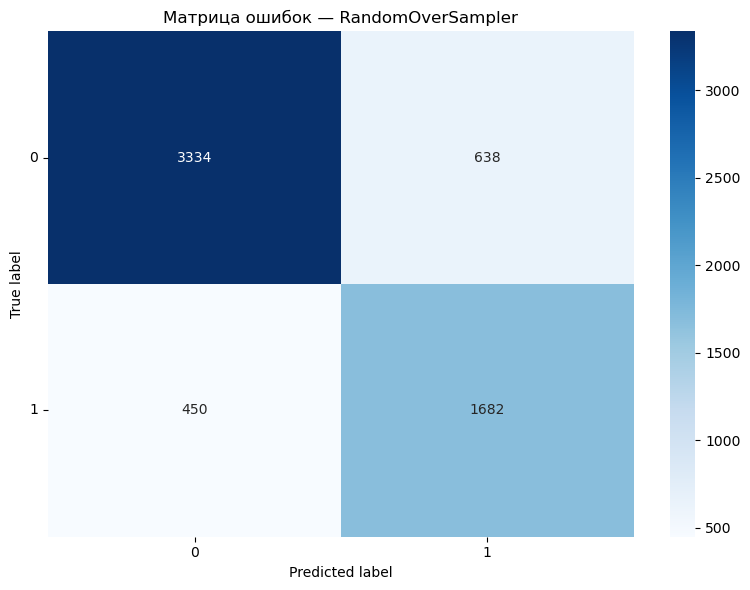

In [ ]:
cm = confusion_matrix(y_train, y_pred_os)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Ноль выгоды по сравнению с class_weight, добавляет риск переобучения (из-за дублирования объектов).

## 5. SMOTE

Генерация синтетических объектов класса меньшинства.

In [ ]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_smote = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote.fit(X_train, y_train)
print("SMOTE + логрегрессия")
print("Лучшие параметры:", gs_smote.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote.best_score_)

SMOTE + логрегрессия
Лучшие параметры: {'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.788933601609658


In [ ]:
y_pred_smote = cross_val_predict(
    gs_smote.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.79      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.81      0.81      6104
weighted avg       0.83      0.82      0.82      6104



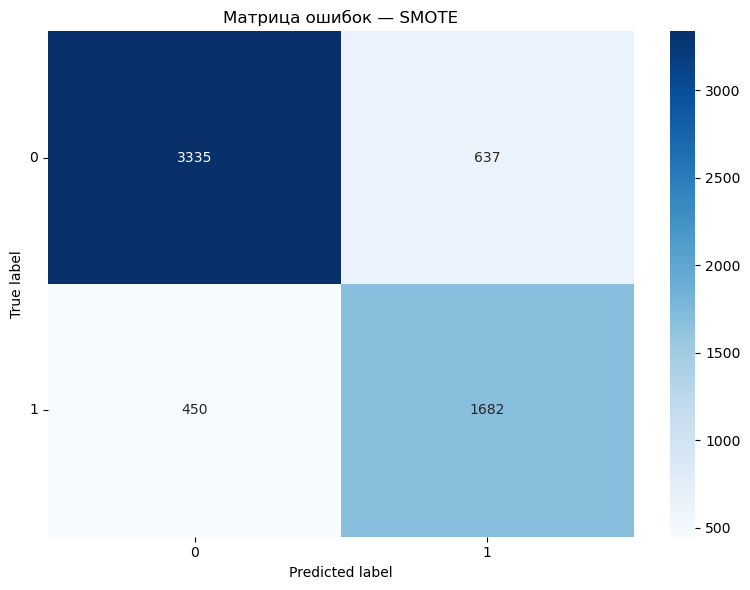

In [ ]:
cm = confusion_matrix(y_train, y_pred_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: очень близко к class_weight и oversampling по качеству.

## Общий пайплайн

In [27]:
pipeline_combined = ImbPipeline([
    ("preprocess", preprocessor),
    ("sampler", "passthrough"), 
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_combined = {
    'sampler': [
        'passthrough',                                   
        RandomUnderSampler(random_state=RANDOM_STATE),   
        RandomOverSampler(random_state=RANDOM_STATE),    
        SMOTE(random_state=RANDOM_STATE, k_neighbors=5)  
    ],
    'logreg__C': [0.01, 0.05, 0.1, 0.2, 0.3],
    'logreg__l1_ratio': [0, 0.25, 0.5, 0.625, 0.75, 1],
    'logreg__penalty': ['elasticnet'],
    'logreg__solver': ['saga'],
    'logreg__class_weight': [None, 'balanced']
}

gs_combined = GridSearchCV(
    pipeline_combined,
    param_grid=param_grid_combined,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

gs_combined.fit(X_train, y_train)

print("\n" + "="*50)
print("Лучший результат общего пайплайна:")
print(f"Best params: {gs_combined.best_params_}")
print(f"Best Recall: {gs_combined.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Лучший результат общего пайплайна:
Best params: {'logreg__C': 0.2, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.75, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga', 'sampler': RandomUnderSampler(random_state=42)}
Best Recall: 0.7950


In [28]:
y_pred_combined = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам:")
print(classification_report(y_train, y_pred_combined))

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



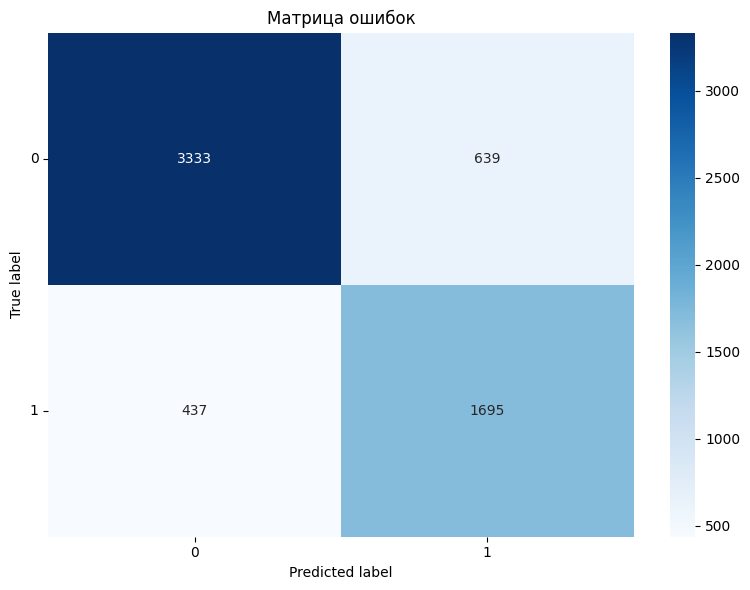

In [29]:
cm = confusion_matrix(y_train, y_pred_combined)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

## Промежуточный вывод

В контексте задачи лучше всего себя показал **общий пайплайн** (General Pipeline), подобравший комбинацию **RandomUnderSampler** и логистической регрессии с **ElasticNet** регуляризацией.

Почему:

- Лучший показатель Recall на кросс-валидации (**0.795**), что выше, чем у простого взвешивания классов (0.791) и у базовой модели (0.69).

- Использование сэмплирования (UnderSampler) в данном случае помогло сбалансировать выборку эффективнее, чем простое взвешивание.

- не требует изменения данных (в отличие от sampling-подходов и SMOTE), т.е. проще и надёжнее

Что всё-таки важнее — FP или FN?

FN — это пропуск тяжёлого пациента:

- потенциально пропущенная угроза жизни

- поздняя диагностика

- потеря шанса на трансплантацию

FP — это ложная отправка на более глубокое обследование:

- пациент пойдёт повторую диагностику

- это дополнительные затраты

Вывод: максимизируем recall, т.е. нужно снижать FN, пусть даже ценой большего количества FP. Иными словами, лучше проверить лишнего пациента, чем пропустить тяжёлого.

## Изменение порога

Выбираем лучшую модель из **общего пайплайна** и пробуем настроить индивидуальный порог, чтобы добиться нужного баланса FP/FN.

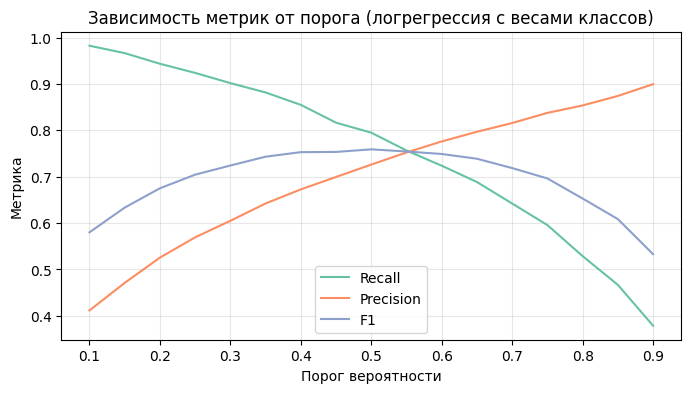

In [30]:
y_proba_combined = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for thr in thresholds:
    y_thr = (y_proba_combined >= thr).astype(int)
    recalls.append(recall_score(y_train, y_thr))
    precisions.append(precision_score(y_train, y_thr))
    f1s.append(f1_score(y_train, y_thr))

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Порог вероятности")
plt.ylabel("Метрика")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Зависимость метрик от порога (логрегрессия с весами классов)")
plt.show()

Выполним новый предикт с выбранным порогом. Хотим найти как можно больше тяжёлых пациентов, но при этом избежать слишком большого кол-ва ложноположительных.

In [39]:
THRESHOLD = 0.3

y_pred_combined_thr = (y_proba_combined >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_combined_thr))

Отчёт по классам (лучшая модель с порогом 0.3):
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3972
           1       0.60      0.90      0.72      2132

    accuracy                           0.76      6104
   macro avg       0.77      0.79      0.76      6104
weighted avg       0.82      0.76      0.77      6104



И "радикальный" вариант: попробуем не ошибаться с тяжёлыми пациентами вообще. Будем ловить много ложноположительных, но при этом какой-то процент пациентов мы смело можем относить к лёгкой стадии.

In [37]:
THRESHOLD = 0.1

y_pred_combined_thr = (y_proba_combined >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_combined_thr))

Отчёт по классам (лучшая модель с порогом 0.1):
              precision    recall  f1-score   support

           0       0.96      0.25      0.39      3972
           1       0.41      0.98      0.58      2132

    accuracy                           0.50      6104
   macro avg       0.69      0.61      0.49      6104
weighted avg       0.77      0.50      0.46      6104



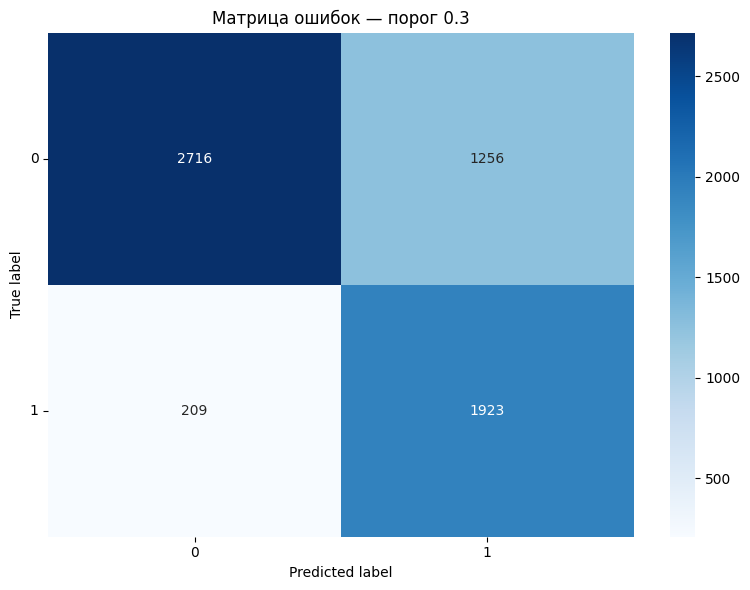

In [41]:
cm = confusion_matrix(y_train, y_pred_combined_thr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Матрица ошибок — порог {THRESHOLD}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

# Этап III. Проверка на тесте

Обучаем лучшую модель (General Pipeline) на всём трейне с выбранным порогом, строим график feature importances и делаем предикт для теста.

In [42]:
best_params = gs_combined.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'logreg__C': 0.2, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.75, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga', 'sampler': RandomUnderSampler(random_state=42)}


In [44]:
final_pipeline = ImbPipeline([
    ("preprocess", preprocessor),
    ("sampler", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("logreg", LogisticRegression(
        random_state=RANDOM_STATE,
        penalty=best_params["logreg__penalty"],
        solver=best_params["logreg__solver"],
        n_jobs=-1,
        class_weight=best_params["logreg__class_weight"],
        C=best_params["logreg__C"],
        l1_ratio=best_params["logreg__l1_ratio"]
    ))
])

# обучение на всём train
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_skewed',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('clip',
                                                                   PercentileClipper(columns=['Bilirubin',
                                                                                              'Cholesterol',
                                                                                              'Copper',
                                                                                              'Alk_Phos',
                                                                                              'SGOT',
                                                                                              'Tryglicerides',
                                                                                              'Prothrombin'],
                                                                                     upper=99)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Bilirubin', 'Chole...
                                                                        'Spiders': {'N': 0,
                                                                                    'Y': 1}}),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders']),
                                                 ('category',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Edema', 'Stage'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('logreg',
                 LogisticRegression(C=0.2, l1_ratio=0.75, n_jobs=-1,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [45]:
preprocess_step = final_pipeline.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()

# кэфы логрегрессии
logreg_step = final_pipeline.named_steps["logreg"]
coefs = logreg_step.coef_[0]

# формируем таблицу feature importances
fi = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

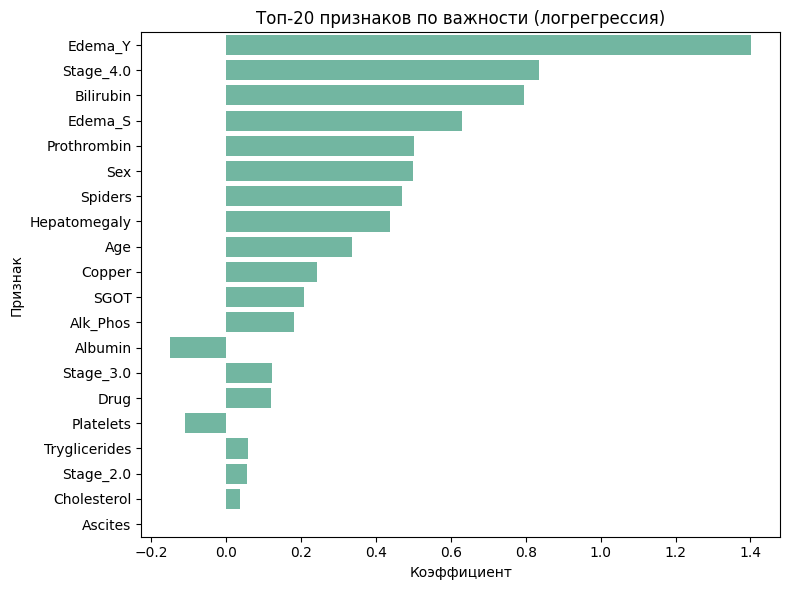

In [46]:
TOP_N = 20

plt.figure(figsize=(8, 6))
sns.barplot(data=fi.head(TOP_N), x="coef", y="feature")
plt.xlabel("Коэффициент")
plt.ylabel("Признак")
plt.title(f"Топ-{TOP_N} признаков по важности (логрегрессия)")
plt.tight_layout()
plt.show()

- Наибольший вклад в риск тяжёлого течения (класс 1) дают отёки: наличие Edema_Y и Edema_S резко повышает вероятность тяжёлого статуса.

- Продвинутые стадии болезни (Stage_4.0, Stage_3.0, Stage_2.0) сильно связаны с тяжёлым исходом — чем выше стадия, тем выше риск.

- Среди числовых показателей важны: Bilirubin и Prothrombin — их рост увеличивает вероятность тяжёлого статуса.

- Hepatomegaly также вносит заметный вклад. Spiders, Ascites и факт приёма Drug тоже влияют, но уже меньше.

- Отрицательные коэффициенты у Albumin и Platelets: их более высокие значения, наоборот, связаны с меньшим риском тяжёлого течения.

In [47]:
THRESHOLD = 0.3

y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= THRESHOLD).astype(int)

In [48]:
print(f"Отчёт по классам на тесте (threshold={THRESHOLD}):")
print(classification_report(y_test, y_pred_test))

Отчёт по классам на тесте (threshold=0.3):
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       993
           1       0.59      0.90      0.71       533

    accuracy                           0.75      1526
   macro avg       0.76      0.78      0.75      1526
weighted avg       0.81      0.75      0.75      1526



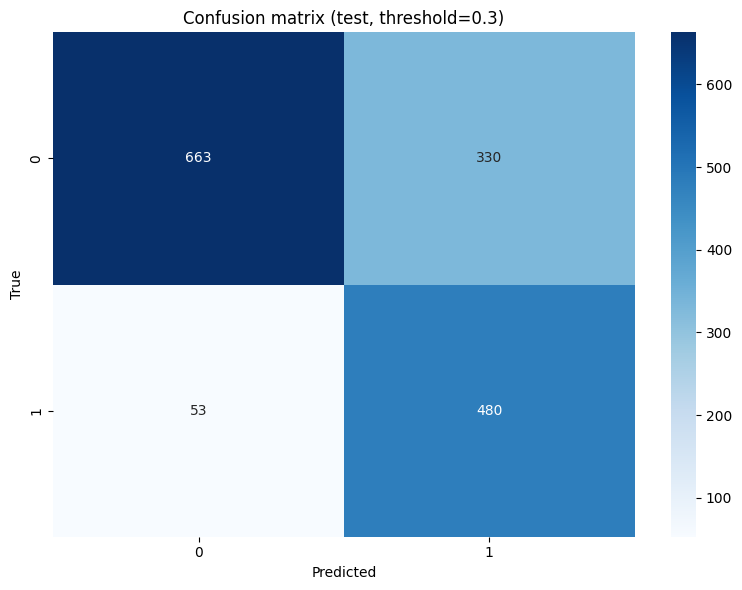

In [49]:
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix (test, threshold={THRESHOLD})")
plt.tight_layout()
plt.show()

recall = 0.90 — модель находит подавляющее большинтво всех тяжёлых пациентов.
precision = 0.59 — около 40% помеченных как тяжёлые окажутся не тяжёлыми => их можно отправлять на дообследование.

Для класса 0 (нет тяжёлого течения):
precision = 0.93 — если модель говорит, что тяжёлого течения нет, ей почти всегда можно доверять.

Вывод: при пороге 0.3 модель настроена как "скрининговая": она делает упор на минимизацию пропусков тяжёлых случаев, сознательно допуская больше ложноположительных, которых можно отфильтровать на этапе углублённой диагностики.

## Выводы

**Предобработка:**

Оптимальной является стратегия log -> клиппинг -> StandardScaler для "скошенных" числовых признаков. Бинарные закодированы в 0/1, многокатегориальные — OHE. Признаки приведены к примерно одинаковому масштабу.

**Моделирование:**

Проведена оценка разных моделей логистической регрессии. Лучший результат показал **Общий пайплайн** (RandomUnderSampler + LogReg ElasticNet). Дополнительная настройка порога (0.3) повысила чувствительность к классу тяжёлых пациентов.

**Результаты:**

На тесте модель показывает recall класса 1 = 0.90 и приемлемый precision = 0.59, что делает её подходящей для раннего скрининга тяжёлых случаев. Важнейшие признаки: Edema, Stage, Bilirubin, Prothrombin и Hepatomegaly.